## Librerías y carga del dataset

In [1]:
import pandas as pd
import tensorflow as tf

# Cargar dataset de tweets
url = "https://raw.githubusercontent.com/dD2405/Twitter_Sentiment_Analysis/master/train.csv"
csv_path = tf.keras.utils.get_file("twitter_sentiment.csv", url)
df = pd.read_csv(csv_path)

# Ver primeras filas
df.head()


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


## Exploración básica

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB
id       0
label    0
tweet    0
dtype: int64


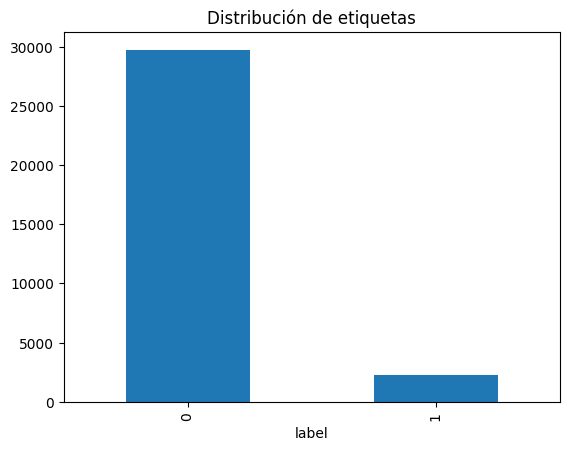

In [2]:
# Información general
df.info()

# Ver si hay valores nulos
print(df.isnull().sum())

# Distribución de clases (0=negativo, 1=positivo)
df['label'].value_counts().plot(kind='bar', title='Distribución de etiquetas');


In [3]:
df['label'].value_counts().sort_index()


label
0    29720
1     2242
Name: count, dtype: int64

In [4]:
df['label'].value_counts().rename_axis('Label').reset_index(name='Cantidad')


,Label,Cantidad
0,0,29720
1,1,2242


## Limpieza de texto con stopwords y eliminación de ruido

In [5]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'http\S+', '', texto)       # URLs
    texto = re.sub(r'@\w+', '', texto)          # menciones
    texto = re.sub(r'#\w+', '', texto)          # hashtags
    texto = re.sub(r'[^\x00-\x7F]+', ' ', texto)  # emojis y no-ASCII
    texto = re.sub(r'[^\w\s]', '', texto)       # puntuación
    texto = re.sub(r'\d+', '', texto)           # números
    texto = re.sub(r'\s+', ' ', texto).strip()  # espacios extra
    palabras = texto.split()
    palabras_filtradas = [p for p in palabras if p not in stop_words]
    return ' '.join(palabras_filtradas)

# Aplicar limpieza
df['tweet_limpio'] = df['tweet'].apply(limpiar_texto)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\herny\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
df.shape

(31962, 4)

In [7]:
df['label'].value_counts().rename_axis('Label').reset_index(name='Cantidad')

,Label,Cantidad
0,0,29720
1,1,2242


##  Eliminar vacíos o textos muy cortos

In [8]:
# Eliminar tweets vacíos o muy cortos después de limpieza
df = df[df['tweet_limpio'].str.len() > 2]

# Ver un ejemplo de comparación
df[['tweet', 'tweet_limpio']].sample(5)


,tweet,tweet_limpio
697,#nature_perfection bull hill climb: you have...,bull hill climb reach target complete task sur...
27627,@user ene mene miney moe....time to play #ris...,ene mene miney moetime play hoe
17843,#sorry #potus this #bigotry is fully #american...,fully blasts
28852,a little polski sklep is good for you and me! ...,little polski sklep good
26015,"""new"" paladino loving eggs like this shit hea...",new paladino loving eggs like shit head bitchi...


## Visualización de palabras frecuentes por clase (opcional)

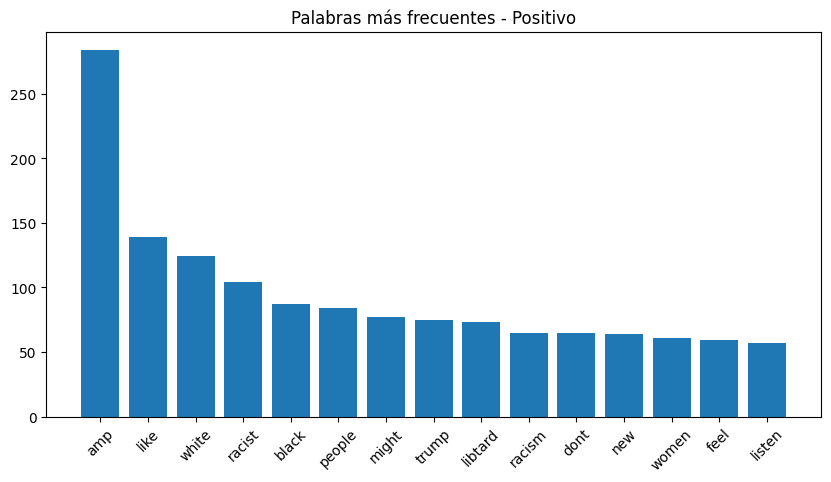

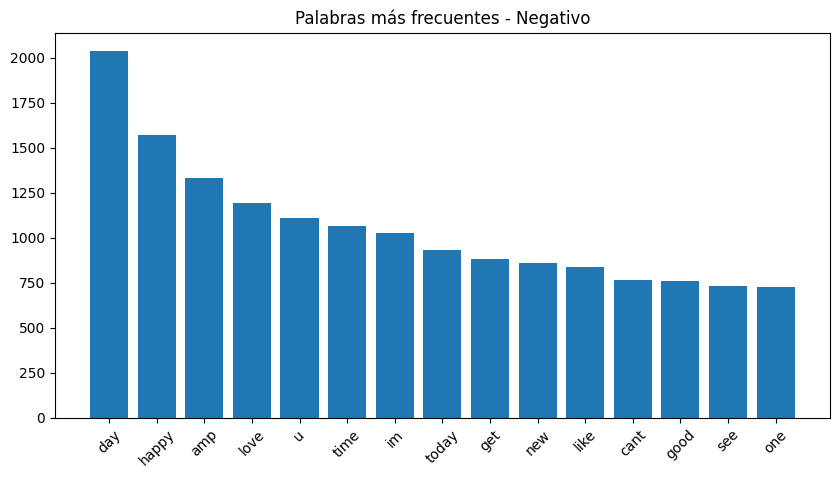

In [9]:
from collections import Counter
import matplotlib.pyplot as plt

def graficar_frecuentes(textos, etiqueta):
    todas = ' '.join(textos).split()
    freqs = Counter(todas).most_common(15)
    palabras, cantidades = zip(*freqs)
    plt.figure(figsize=(10,5))
    plt.bar(palabras, cantidades)
    plt.title(f"Palabras más frecuentes - {etiqueta}")
    plt.xticks(rotation=45)
    plt.show()

# Tweets positivos
graficar_frecuentes(df[df['label'] == 1]['tweet_limpio'], "Positivo")

# Tweets negativos
graficar_frecuentes(df[df['label'] == 0]['tweet_limpio'], "Negativo")


## 1. Análisis estadístico del texto
Longitud promedio de los tweets (originales y limpios).

Distribución de longitud para saber cuánto padding usar más adelante.

In [10]:
# Longitud de tweets originales y limpios
df['len_original'] = df['tweet'].apply(len)
df['len_limpio'] = df['tweet_limpio'].apply(len)

# Estadísticas descriptivas
df[['len_original', 'len_limpio']].describe()


,len_original,len_limpio
count,31403.000000,31403.000000
mean,85.044805,34.834411
std,29.369541,21.756493
min,11.000000,3.000000
25%,63.000000,17.000000
50%,88.000000,31.000000
75%,108.000000,49.000000
max,274.000000,127.000000


Text(0.5, 0, 'Número de caracteres')

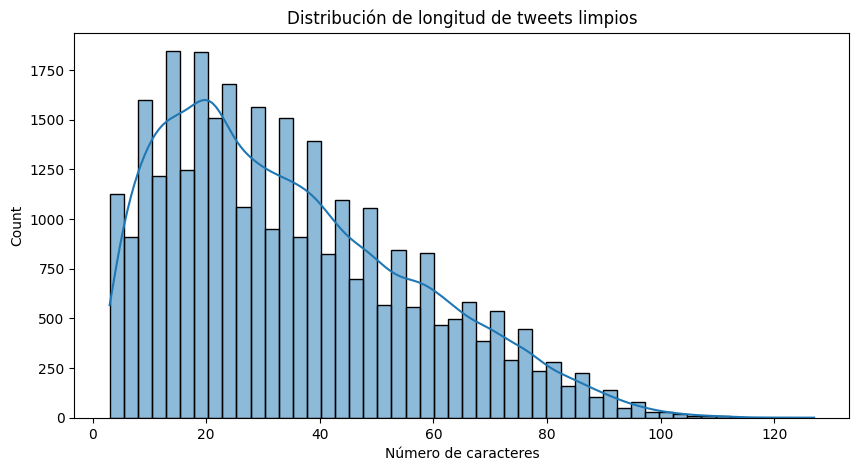

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.histplot(df['len_limpio'], bins=50, kde=True)
plt.title("Distribución de longitud de tweets limpios")
plt.xlabel("Número de caracteres")


## 2. Conteo de palabras por tweet (tokens)

In [12]:
df['num_tokens'] = df['tweet_limpio'].apply(lambda x: len(x.split()))
df['num_tokens'].describe()

count    31403.000000
mean         5.609400
std          3.363348
min          1.000000
25%          3.000000
50%          5.000000
75%          8.000000
max         21.000000
Name: num_tokens, dtype: float64

## Wordcloud (nube de palabras)

Visualmente atractivo para el informe o presentación

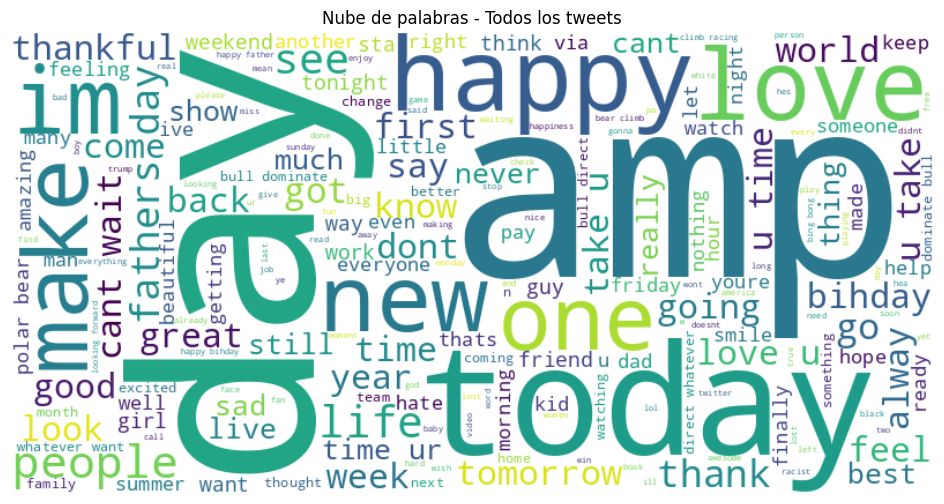

In [13]:
from wordcloud import WordCloud

# Nube de palabras general
texto_total = ' '.join(df['tweet_limpio'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_total)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de palabras - Todos los tweets")
plt.show()


## 4. Guardar dataset limpio (opcional)
Esto sirve para no tener que repetir la limpieza en cada notebook.

In [14]:
# df[['tweet_limpio', 'label']].to_csv("../data/tweets_limpios.csv", index=False)